In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize

from consav import linear_interp, linear_interp_1d

import Bargaining as brg

from figures import *

# plot style
# linestyles = ['-','--','-.',':',':']
# markers = ['o','s','D','*','P']
# linewidth = 2
# font_size = 14
# font = {'size':font_size}
# matplotlib.rc('font', **font)

# plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

# c++ settings
do_cpp = True
do_compile = True
threads = 16


from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

## Plot different cases

In [2]:
# font_size = 15
    
# # Apply style and font size
# plt.style.use('default')  # Use default style (no grid lines)
# plt.rcParams.update({'font.size': font_size, 'font.family': 'serif', 'font.serif': 'Times New Roman'})

In [3]:
def plot_surplus_simple(Sw, Sm, grid_power, fix_axes=True, title=None, ax=None):
    # If ax is not provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots()
    
    
    ax.plot(grid_power,Sw, label='Woman', color=colors['red'])
    ax.plot(grid_power,Sm, label='Man', color=colors['blue'])
    ax.axhline(0, color='black', linewidth=1, linestyle='--')
    
    # Layout
    ax.set_xlabel('Power of member 1, $\mu$')
    ax.set_ylabel('Marital surplus, $s$')
    if title is not None:
        ax.set_title(title)
    # ax.legend()
    
    ax.annotate("Member 1", xy=(grid_power[-1], Sw[-1]), xytext=(grid_power[-1]-0.32, Sw[-1]+0.3), color=colors['red'])
    ax.annotate("Member 2", xy=(grid_power[-1], Sm[-1]), xytext=(grid_power[-1]-0.32, Sm[-1]+0.0), color=colors['blue'])
    
    # Make sure the axis is on the same scale
    if fix_axes:
        ax.set_ylim([-3,3])
        ax.set_xlim([0,1])
        
    ###  Add indifference point annotation
    # find where S crosses x-axis
    interp_power_at_zero_w = linear_interp_1d.interp_1d(Sw, grid_power, 0.0)
    interp_power_at_zero_m = linear_interp_1d.interp_1d(-Sm, grid_power, 0.0)

    # Handle cases where there is no indifference point
    indifference_point_w = True
    indifference_point_m = True
    if interp_power_at_zero_w < 0 or interp_power_at_zero_w > 1:
        interp_power_at_zero_w = 0
        indifference_point_w = False
    if interp_power_at_zero_m < 0 or interp_power_at_zero_m > 1:
        interp_power_at_zero_m = 1
        indifference_point_m = False

        
    # Plot indifference point
    if indifference_point_w:
        ax.plot(interp_power_at_zero_w, 0, marker='o', color=colors['red'], markersize=5)
        ax.annotate("$\\tilde{\mu}_1$", xy=(interp_power_at_zero_w, 0), xytext=(interp_power_at_zero_w+0.02, -0.65), color=colors['red'], fontsize=font_size)
    if indifference_point_m:
        ax.plot(interp_power_at_zero_m, 0, marker='o', color=colors['blue'], markersize=5)
        ax.annotate("$\\tilde{\mu}_2$", xy=(interp_power_at_zero_m, 0), xytext=(interp_power_at_zero_m+0.02, -0.65), color=colors['blue'], fontsize=font_size)
    
    return ax


In [4]:
def plot_power_shift(Sw, Sm, grid_power, title=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    
    # find where S crosses x-axis
    interp_power_at_zero_w = linear_interp_1d.interp_1d(Sw, grid_power, 0.0)
    interp_power_at_zero_m = linear_interp_1d.interp_1d(-Sm, grid_power, 0.0)

    # Handle cases where there is no indifference point
    indifference_point_w = True
    indifference_point_m = True
    if interp_power_at_zero_w < 0 or interp_power_at_zero_w > 1:
        interp_power_at_zero_w = 0
        indifference_point_w = False
    if interp_power_at_zero_m < 0 or interp_power_at_zero_m > 1:
        interp_power_at_zero_m = 1
        indifference_point_m = False
        
    # Handle divorce case
    divorce = False
    if np.max(Sw)<0 or np.max(Sm)<0:
        divorce = True
    if interp_power_at_zero_m < interp_power_at_zero_w:
        divorce = True
    
    
    # Create grid for plotting
    low_grid = [power for power in grid_power if power < interp_power_at_zero_w]
    middle_grid = [power for power in grid_power if power >= interp_power_at_zero_w and power <= interp_power_at_zero_m]
    high_grid = [power for power in grid_power if power > interp_power_at_zero_m]
    
    # combine grids
    x_grid = np.concatenate((low_grid, [interp_power_at_zero_w], middle_grid, [interp_power_at_zero_m], high_grid))
    y_grid = np.concatenate(([interp_power_at_zero_w]*len(low_grid), [interp_power_at_zero_w], middle_grid, [interp_power_at_zero_m], [interp_power_at_zero_m]*len(high_grid)))

    # Plot
    ax.plot(grid_power,grid_power, color = colors['black'], linewidth = 1.0, linestyle='--')
    
    if divorce==False:
        ax.plot(x_grid, y_grid, color = colors['black'], linewidth = 2.0)
        # ax.plot(low_grid, [interp_power_at_zero_w]*len(low_grid), color = colors['red'], linewidth = 3.0)
        # ax.plot(high_grid, [interp_power_at_zero_m]*len(high_grid), color = colors['blue'], linewidth = 3.0)
    
        # annotate
        if indifference_point_w:
            ax.axvline(x=interp_power_at_zero_w, color=colors['gray_dark'],linestyle=':', label='$\mu_{1}$')
            ax.annotate("$\\tilde{\mu}_{1}$", xy=(interp_power_at_zero_w, interp_power_at_zero_w), xytext=(interp_power_at_zero_w+0.01, interp_power_at_zero_w-0.04), color=colors['red'], fontsize=font_size)
        if indifference_point_m:
            ax.axvline(x=interp_power_at_zero_m, color=colors['gray_dark'],linestyle=':', label='$\mu_{2}$')
            ax.annotate("$\\tilde{\mu}_{2}$", xy=(interp_power_at_zero_m, interp_power_at_zero_m), xytext=(interp_power_at_zero_m-0.05, interp_power_at_zero_m+0.01), color=colors['blue'], fontsize=font_size)
    
    # Add labels
    ax.set_xlabel('Previous bargaining power, $\mu_{t-1}$')
    ax.set_ylabel('Updated bargaining power, $\mu_t$')
    
    # Make sure the axis is square from 0 to 1
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    
    return ax
    
    

## Create curves

In [5]:
# generate fictive surplus functions
num_power = 200
grid_power = np.linspace(0, 1, num_power)

def never_happy(grid_power):
    return np.log(0.01+grid_power)/2 + 0.1
def sometimes_happy_high(grid_power):
    return never_happy(grid_power) + 0.7
def sometimes_happy_low(grid_power):
    return never_happy(grid_power) + 0.3
def always_happy(grid_power):
    return never_happy(grid_power) + 2.7


w_never_happy = never_happy(grid_power)
w_always_happy = always_happy(grid_power)
w_sometimes_happy_high = sometimes_happy_high(grid_power)
w_sometimes_happy_low = sometimes_happy_low(grid_power)
power_at_zero_w_high = linear_interp_1d.interp_1d(w_sometimes_happy_high,grid_power, 0.0)

asym = - 0.3
m_never_happy = np.flip(w_never_happy) + asym
m_always_happy = np.flip(w_always_happy) + asym
m_sometimes_happy_high = np.flip(w_sometimes_happy_high) + asym
m_sometimes_happy_low = np.flip(w_sometimes_happy_low) + asym
power_at_zero_m_high = 1-power_at_zero_w_high

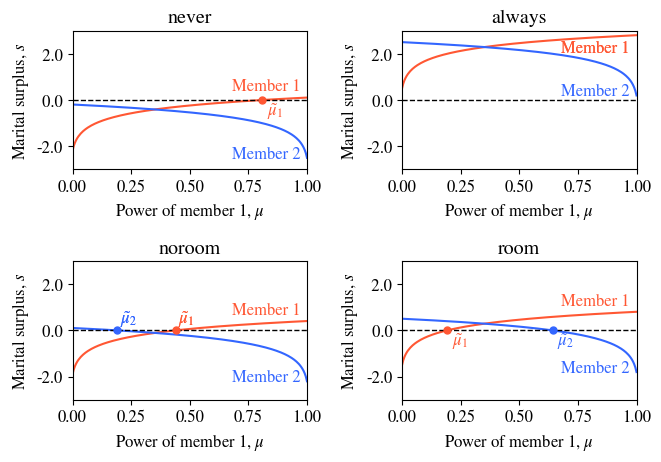

In [6]:
fig, ax = make_fig(num_plots=4,dimensions=(2,2))
ax0 = plot_surplus_simple(w_never_happy, m_never_happy, grid_power, ax=ax[0], title='never')
ax1 = plot_surplus_simple(w_always_happy, m_always_happy, grid_power, ax=ax[1], title='always')
ax2 = plot_surplus_simple(w_sometimes_happy_low, m_sometimes_happy_low, grid_power, ax=ax[2], title='noroom')
ax3 = plot_surplus_simple(w_sometimes_happy_high, m_sometimes_happy_high, grid_power, ax=ax[3], title='room')


# Move member 1 of ax1
for annotation in ax1.texts:
    if 'Member 1' in annotation.get_text():
        annotation.remove()
    ax1.annotate("Member 1", xy=(grid_power[-1], w_always_happy[-1]), xytext=(grid_power[-1]-0.32, w_always_happy[-1]-0.75), color=colors['red'])

# Move mu of ax2
for annotation in ax2.texts:
    if 'mu' in annotation.get_text():
        annotation.remove()
        power_at_zero_w_high = linear_interp_1d.interp_1d(w_sometimes_happy_low, grid_power, 0.0)
        power_at_zero_m_high = linear_interp_1d.interp_1d(m_sometimes_happy_low, grid_power, 0.0)

        ax2.annotate("$\\tilde{\mu}_{1}$", xy=(power_at_zero_w_high, 0), xytext=(power_at_zero_w_high+0.01, 0.3), color=colors['red'], fontsize=font_size)
        ax2.annotate("$\\tilde{\mu}_2$",   xy=(power_at_zero_m_high, 0), xytext=(power_at_zero_m_high-0.01, 0.3), color=colors['blue'], fontsize=font_size)

for axe in [ax0, ax1, ax2, ax3]:
    axe.yaxis.set_major_formatter(FormatStrFormatter('%4.1f'))
    
fig.tight_layout()

fig_name = 'bargaining'
save_subplots(fig, fig_name)

## Illustrate interpolation

In [7]:
power_at_zero_w_high = linear_interp_1d.interp_1d(w_sometimes_happy_high, grid_power, 0.0)
power_at_zero_m_high = linear_interp_1d.interp_1d(-m_sometimes_happy_high, grid_power, 0.0)

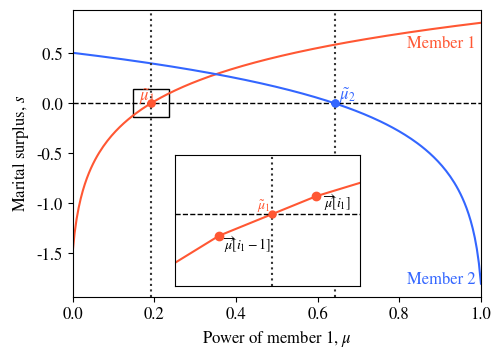

In [8]:
# Make coarse grid
coarse_grid_power = np.linspace(power_at_zero_w_high-0.1, power_at_zero_w_high+0.1, 4)
coarse_w_sometimes_happy_high = sometimes_happy_high(coarse_grid_power)
if np.isnan(coarse_w_sometimes_happy_high[0]):
    coarse_w_sometimes_happy_high[0] = w_sometimes_happy_high[0]
    coarse_grid_power[0] = grid_power[0]

# make a plot
fig, ax = make_fig(num_plots=1,dimensions=(1,1))
ax = plot_surplus_simple(w_sometimes_happy_high, m_sometimes_happy_high, grid_power, fix_axes=False, ax=ax[0])

# Legends / Annotations
# ax.legend(loc='upper right')
ax.axvline(x=power_at_zero_w_high, color=colors['gray_dark'],linestyle=':', label='$\mu_1$')
ax.axvline(x=power_at_zero_m_high, color=colors['gray_dark'],linestyle=':', label='$\mu_2$')

# Replace annotations
# remove annotations from fig
for annotation in ax.texts:
    annotation.remove()
ax.annotate("Member 1", xy=(grid_power[-1], w_sometimes_happy_high[-1]), xytext=(grid_power[-1]-0.18, w_sometimes_happy_high[-1]-0.25), color=colors['red'])
ax.annotate("Member 2", xy=(grid_power[-1], m_sometimes_happy_high[-1]), xytext=(grid_power[-1]-0.18, m_sometimes_happy_high[-1]+0.00), color=colors['blue'])

ax.plot(power_at_zero_w_high, 0, marker='o', color=colors['red'], markersize=5)
ax.annotate("$\\tilde{\mu}_1$", xy=(power_at_zero_w_high, 0), xytext=(power_at_zero_w_high-0.03, 0.03), color=colors['red'], fontsize=font_size)
ax.plot(power_at_zero_m_high, 0, marker='o', color=colors['blue'], markersize=5)
ax.annotate("$\\tilde{\mu}_2$", xy=(power_at_zero_m_high, 0), xytext=(power_at_zero_m_high+0.01, 0.04), color=colors['blue'], fontsize=font_size)

ax.set_xlim([0,1])

# ZOOM PLOT - make an overlaying plot that focues on the vertical line at power_at_zero_w_high and place in the bottom right corner
# Location of the overlaying plot

min_x = coarse_grid_power[1]-0.03
max_x = coarse_grid_power[2]+0.03
x_range = max_x-min_x

min_y = -0.3
max_y = 0.25
y_range = max_y-min_y

left, bottom, width, height = [0.32, 0.14, 0.35, 0.35]
ax2 = fig.add_axes([left, bottom, width, height]) # [left, bottom, width, height]

# Convert coordinates from graph to plot
ax2_x = (power_at_zero_w_high-min_x)/x_range
ax2_y = (0.0-min_y)/y_range

# get length of X axis in ax
x_axis_length = ax.get_xlim()[1]-ax.get_xlim()[0]
y_axis_length = ax.get_ylim()[1]-ax.get_ylim()[0]
left_coord = ax.get_xlim()[0] + left * x_axis_length
bottom_coord = ax.get_ylim()[0] + bottom * y_axis_length


# Make plot
ax2.scatter(coarse_grid_power, coarse_w_sometimes_happy_high, color=colors['red'])
ax2.plot(coarse_grid_power, coarse_w_sometimes_happy_high, color=colors['red'], label='Interpolated surplus')

# Interpolated point
ax2.axhline(y=0, color='black',linestyle='--', linewidth=1.0)
interp_power_at_zero = linear_interp_1d.interp_1d(coarse_w_sometimes_happy_high, coarse_grid_power, 0.0)
# ax2.scatter(interp_power_at_zero, 0.0, color=colors['red'], marker='s', s=50, linewidth=2)

# make a box around the selected area in ax
rect = matplotlib.patches.Rectangle((min_x+0.15*x_range,min_y+0.3*y_range),x_range*0.7,y_range*0.5,linewidth=1,edgecolor='black',facecolor='none')
ax.add_patch(rect)
#True surplus
# ax2.plot(grid_power, w_sometimes_happy_high, color=colors['red'], alpha=0.5, label='True surplus')
# ax2.scatter(power_at_zero_w_high, 0.0, color=colors['red'], marker='x', s=100, linewidth=2)


# remove all labels and titles from ax2
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xticks([])
ax2.set_yticks([])

# adjust limits of ax2
ax2.set_xlim([min_x, max_x])
ax2.set_ylim([min_y,max_y])

# Labels and annotations
# place the legend for ax2 to the right of ax2
# ax2.legend(loc='center left', bbox_to_anchor=(-0.0, 0.85), frameon=False)
ax2.axvline(x=interp_power_at_zero, color=colors['gray_dark'],linestyle=':', label='')

ax2.annotate('$\overrightarrow{\mu}[i_1-1]$', xy=(coarse_grid_power[1], coarse_w_sometimes_happy_high[1]), xytext=(coarse_grid_power[1]+0.003, coarse_w_sometimes_happy_high[1]-0.06), fontsize=font_size-2)
ax2.annotate('$\overrightarrow{\mu}[i_1]$', xy=(coarse_grid_power[2], coarse_w_sometimes_happy_high[2]), xytext=(coarse_grid_power[2]+0.005, coarse_w_sometimes_happy_high[2]-0.05), fontsize=font_size-2)
# ax2.annotate('$\mu_{1}$', xy=(power_at_zero_w_high, 0), xytext=(power_at_zero_w_high-0.012, +0.08))
ax2.annotate('$\\tilde{\mu}_{1}$', xy=(interp_power_at_zero, 0), xytext=(interp_power_at_zero-0.01, +0.02), color=colors['red'], fontsize=font_size-2)
ax2.plot(interp_power_at_zero, 0, marker='o', color=colors['red'], markersize=5)

# get coordinates of the box in ax2
box = rect.get_bbox()
box_points = box.get_points()
box_x = box_points[0][0]
box_y = box_points[0][1]
box_width = box_points[1][0]-box_points[0][0]
box_height = box_points[1][1]-box_points[0][1]


# Format y-axis
ax.yaxis.set_major_formatter(FormatStrFormatter('%4.1f'))
# ax.yaxis.set_major_locator(MaxNLocator(integer=False, min_n_ticks=12, nbins=6))
# ax.yaxis.set_major_locator(MaxNLocator(3))

In [9]:
fig.savefig(path + 'showcase_interpolation.pdf', bbox_inches='tight')

## Bargaining updates

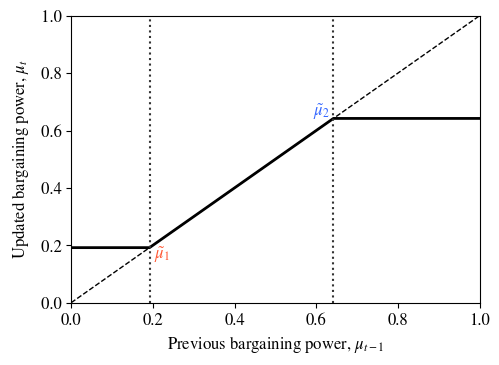

In [10]:
fig, ax = make_fig(num_plots=1,dimensions=(1,1))
ax = plot_power_shift(w_sometimes_happy_high, m_sometimes_happy_high, grid_power, ax=ax[0])


ax.yaxis.set_major_formatter(FormatStrFormatter('%4.1f'))

In [11]:
fig.savefig(path + 'showcase_power_shift.pdf', bbox_inches='tight')